## Multivariate Time Series Forecasting Of Bitcoin With Seasonality Using Prophet In Python

## Step 1: Install And Import Libraries

In [ ]:
###### Step 1: Install and Import Libraries
# Install libraries
!pip install yfinance prophet

In [ ]:
# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


### Step 2: Pull Data
The second step pulls stock data from Yahoo Finance API.

Yahoo finance downloads data with the date as an index. Using reset_index, we created a new index and used the date as a column. This is because Prophet requires the date-time variable to be a column for the model input.

By default, the date is a string type, pd.to_datetime changes it to a DateTime format.

High granularity of data. One cool feature of yfinance is that you can get highly refined data, all the way down to 5 minute, 3 minute and even 1 minute data! The full range of intervals available are:

1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo

We will pull 3 years of daily data from the beginning of 2020 to the end of 2023.

start_date = '2020-11-02' because November 2st is a Monday.

end_date = '2023-11-17' because yfinance excludes the end date, so we need to add one day to the last day of the data end date.

train_end_date = '2023-10-15' means that the splitting date for the training and testing dataset is November 11th of 2023 (Sunday).

__prediction period - week__

In [ ]:
# Download Bitcoin data

# Ticker
ticker='BTC-USD'
# Data start date
start_date = '2020-11-18'
# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
end_date = '2023-11-19'

data = yf.download(tickers=ticker, start=start_date, end=end_date, interval = '1d')
# Reset index and have date as a column
data.reset_index(inplace=True)
# Change date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
# Take a look at the data
data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-18,17645.191406,18393.949219,17352.906250,17804.005859,17804.005859,49064800278
1,2020-11-19,17803.861328,18119.546875,17382.554688,17817.089844,17817.089844,36985055355
2,2020-11-20,17817.083984,18773.226562,17765.794922,18621.314453,18621.314453,36992873940
3,2020-11-21,18621.316406,18936.621094,18444.359375,18642.232422,18642.232422,39650210707
4,2020-11-22,18642.232422,18688.968750,17671.384766,18370.001953,18370.001953,41280434226
...,...,...,...,...,...,...,...
1091,2023-11-14,36491.789062,36753.351562,34948.500000,35537.640625,35537.640625,23857403554
1092,2023-11-15,35548.113281,37964.894531,35383.781250,37880.582031,37880.582031,27365821679
1093,2023-11-16,37879.980469,37934.625000,35545.472656,36154.769531,36154.769531,26007385366
1094,2023-11-17,36164.824219,36704.484375,35901.234375,36596.683594,36596.683594,22445028430


In [ ]:
# Visualization

# Declare a figure
fig = go.Figure()
# Candlestick chart
fig.add_trace(go.Candlestick(x=data.Date,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name = 'Bitcoin Data'))

Prepare data for Prophet

Usually Prophet takes two columns as inputs, a datetime column called ds and a value column called y.

Prophet requires at least two columns as inputs: a ds column and a y column.

Therefore, we need to drop all the other columns, rename Date to ds and Close to y.

The y column has the time series values. In this example, because we are predicting the Bitcoin closing price, the column name close is changed to y.

There is no pre-defined name for the additional predictor in prophet, so we can keep the name Vol as is.

The goal of the time series model is to predict the closing price of Bitcoin stock. The data of Volume will be used as an additional predictor.

In [ ]:
# Keep only date, close price and volume
data = data.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)
# Rename date to ds and close price to y
data.rename(columns={'Date': 'ds', 'Close': 'y', 'Volume': 'Vol'}, inplace=True)
# Take a look at the data
data.head()

,ds,y,Vol
0,2020-11-18,17804.005859,49064800278
1,2020-11-19,17817.089844,36985055355
2,2020-11-20,18621.314453,36992873940
3,2020-11-21,18642.232422,39650210707
4,2020-11-22,18370.001953,41280434226


In [ ]:
# Information on the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1096 non-null   datetime64[ns]
 1   y       1096 non-null   float64       
 2   Vol     1096 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 25.8 KB


Using .info(), we can see that the dataset has 1096 records and three columns, ds, y and Vol.

ds is in DateTime format, and y and Vol are in float format. There is no missing data in the dataset.

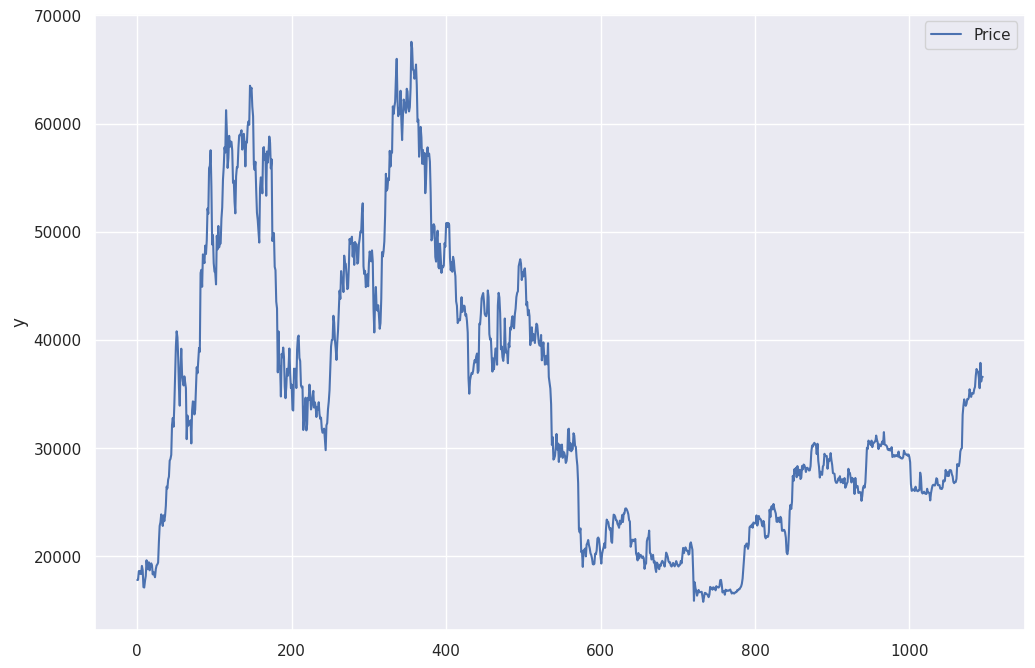

In [ ]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['y'])
plt.legend(['Price'])

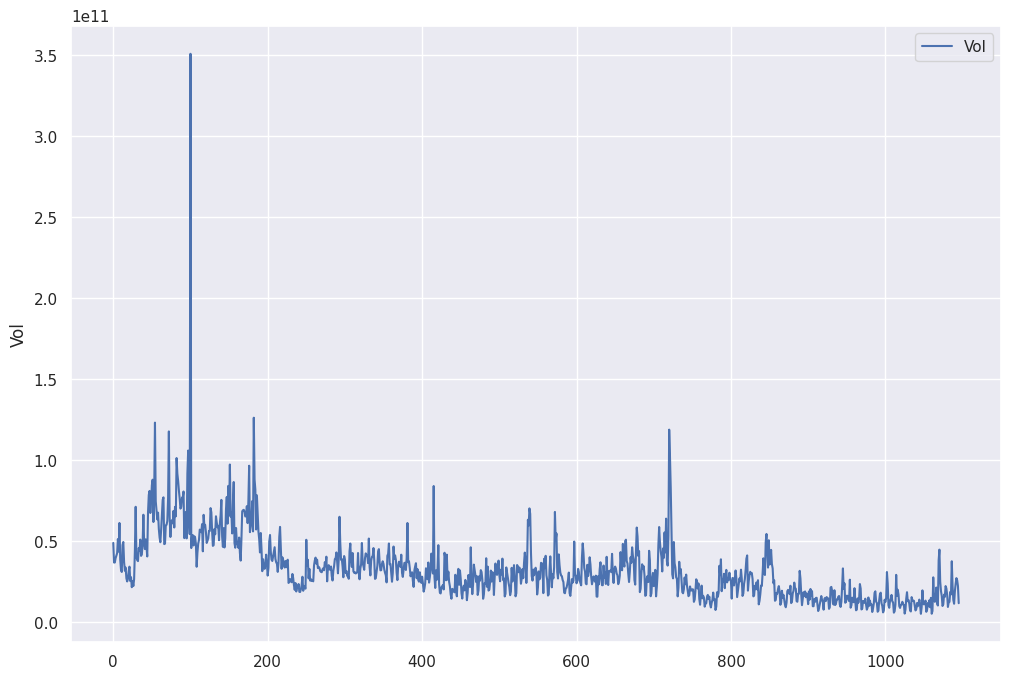

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['Vol'])
plt.legend(['Vol'])

## Step 3: Data Processing

In [ ]:
###### Step 3: Data Processing

# Take a look at the data
data.head()


,ds,y,Vol
0,2020-11-18,17804.005859,49064800278
1,2020-11-19,17817.089844,36985055355
2,2020-11-20,18621.314453,36992873940
3,2020-11-21,18642.232422,39650210707
4,2020-11-22,18370.001953,41280434226


Next, let’s check the correlation between the Bitcoin closing price and the Volume data.

In [ ]:
# Check correlation
data.corrwith(data["y"])

<ipython-input-10-727934c321f9>:2: FutureWarning:

The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



y      1.000000
Vol    0.348033
dtype: float64

The value of 0.348 is lower than 1, indicating that there is a middle correlation between the two closing prices. Therefore, VTI closing price is a potential not very good predictor for the Google closing price.

##Step 4: Train Test Split
In step 4, we will do the train test split. For time series data, usually a threshold date is chosen, then we set the dates before the threshold to be the training dataset and the dates after the threshold to be the testing dataset.

Based on the threshold date (train_end_date) we set before, there are 1090 data points in the training dataset and 6 data points in the testing dataset.

In [ ]:
###### Step 4: Train Test Split

# Data start date
# start_date = '2020-11-18'
# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
# end_date = '2023-11-19'
# Date for splitting training and testing dataset
train_end_date = '2023-11-12'


# Train test split
train = data[data['ds'] <= train_end_date]
test = data[data['ds'] > train_end_date]
# Check the shape of the dataset
print(train.shape)
print(test.shape)

(1090, 3)
(6, 3)


Checking the minimum and maximum values for the train and test dataset separately gave us the starting and ending dates.

In [ ]:
# Check the start and end time of the training and testing dataset
print('The start time of the training dataset is ', train['ds'].min())
print('The end time of the training dataset is ', train['ds'].max())
print('The start time of the testing dataset is ', test['ds'].min())
print('The end time of the testing dataset is ', test['ds'].max())

The start time of the training dataset is  2020-11-18 00:00:00
The end time of the training dataset is  2023-11-12 00:00:00
The start time of the testing dataset is  2023-11-13 00:00:00
The end time of the testing dataset is  2023-11-18 00:00:00


### Step 5: Baseline Model
In step 5, we will build a univariate baseline model using the default prophet hyperparameters, and fit the model using the training dataset.

In [ ]:
###### Step 5: Baseline Model
# Use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()
# Fit the model on the training dataset
model_baseline.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5o70j23w/_oq2ks6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5o70j23w/3asdfl1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64554', 'data', 'file=/tmp/tmp5o70j23w/_oq2ks6u.json', 'init=/tmp/tmp5o70j23w/3asdfl1q.json', 'output', 'file=/tmp/tmp5o70j23w/prophet_model3s5yylq0/prophet_model-20231126131424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:14:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:14:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet automatically fits daily, weekly, and yearly seasonalities if the time series is more than two cycles long.

The model information shows that the daily seasonality are disabled.

The daily seasonality is disabled because we do not have sub-daily time series.

We will continue with the default values for the baseline model and force the yearly seasonality in the next model to see the impact of the yearly seasonality.

To make a forecast, we first need to create a future dataframe. periods=16 means that we would like to make predictions for the next 7 days.

In [ ]:

# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=7)
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)

After making the prediction on the future dataframe, we can plot the result using .plot.

The black dots are the actual values.
The blue line is the prediction.
The blue shades are the uncertainty interval. The default value for the uncertainty interval is 80%, so we are using 80% here. The uncertainty interval is calculated based on the assumption that the average frequency and magnitude of trend changes in the future will be the same as the historical data. The historical data trend changes are projected forward to get the uncertainty intervals [1].

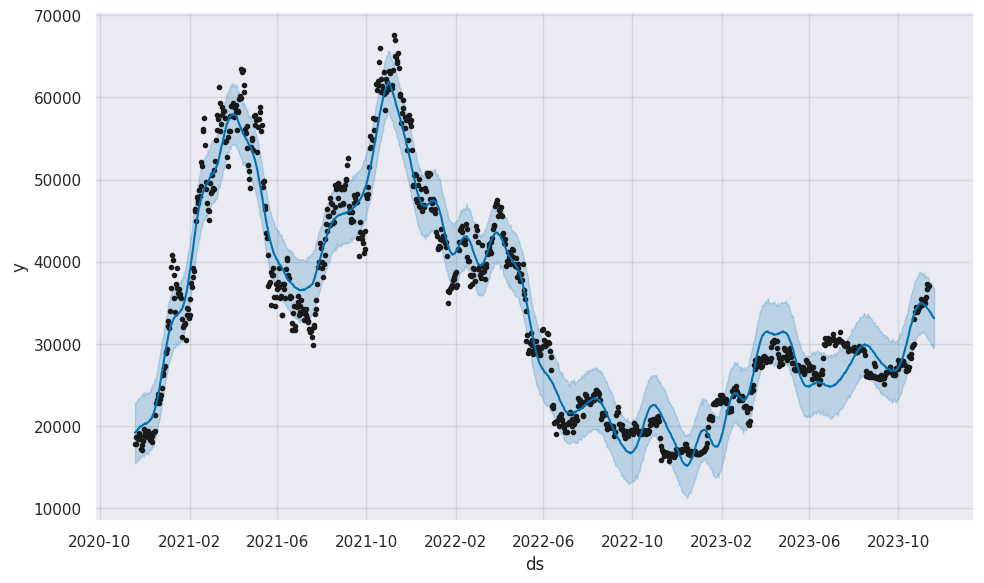

In [ ]:
# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

In addition to the forecast plot, prophet also provides the components plot.

From the component plot chart, we can see that the Google stock closing price has an overall upward trend. The weekly seasonality shows that the price tends to be lower at the beginning of the week and higher at the end of the week.

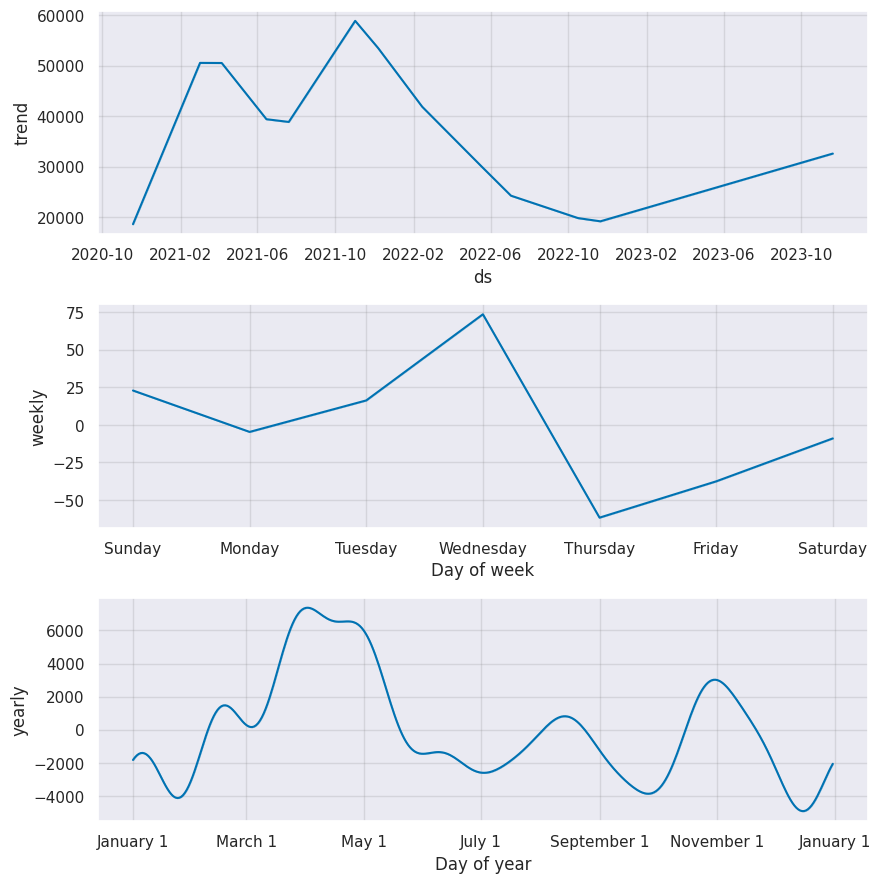

In [ ]:
# Visualize the forecast components
model_baseline.plot_components(forecast_baseline);

Next, let’s check the model performance.

The forecast dataframe does not include the actual values, so we need to merge the forecast dataframe with the test dataframe to compare the actual values with the predicted values.

In [ ]:
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')
# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 2948.1421200168857
The MAPE for the baseline model is 0.08033596067000771


The mean absolute error (MAE) for the baseline model is 2948, meaning that on average, the forecast is off by 2948. Given the Bitcoin price of nearly 30000, the prediction is not bad.

The mean absolute percent error (MAPE) for the baseline model is 8.03%, meaning that on average, the forecast is off by 8.03% of the Bitcoin price.

### Step 6: Add Seasonality To Baseline Model
The baseline model already gives us good estimations. Can we tune the model to make the estimations better? In step 6, we will force the model to consider the yearly seasonality.

When initiating the prophet model, the yearly_seasonality and weekly_seasonality are explicitly set to True, and then fit on the training data.

In [ ]:
###### Step 6: Add Seasonality to Baseline Model
# Add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)
# Fit the model on the training dataset
model_season.fit(train)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5o70j23w/3a_2m866.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5o70j23w/x6ou7lyc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43951', 'data', 'file=/tmp/tmp5o70j23w/3a_2m866.json', 'init=/tmp/tmp5o70j23w/x6ou7lyc.json', 'output', 'file=/tmp/tmp5o70j23w/prophet_modelpk1vc6bk/prophet_model-20231126131429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:14:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:14:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


The forecast plot is appr the same as the baseline model.

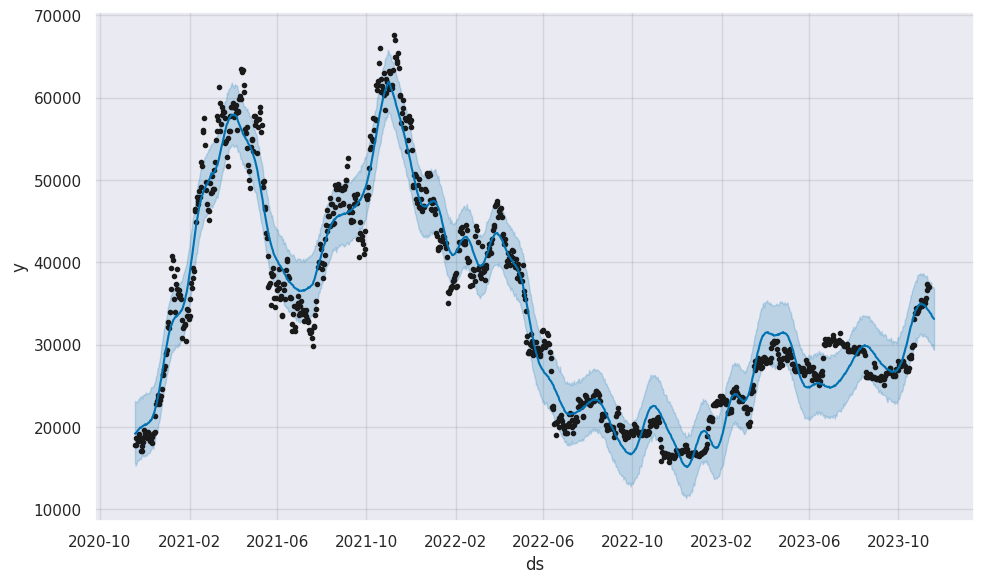

In [ ]:
# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=7)
# Make prediction
forecast_season = model_season.predict(future_season)
# Visualize the forecast
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart

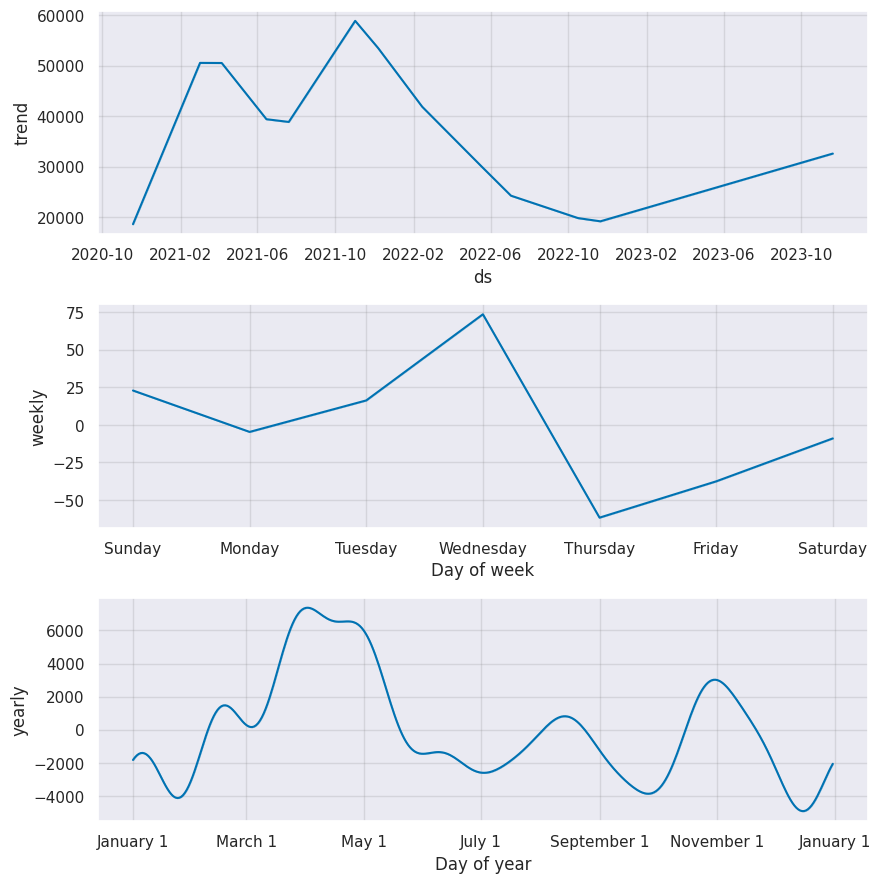

In [ ]:
# Visualize the forecast components
model_season.plot_components(forecast_season);


In [ ]:
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')
# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 2948.1421200168857
The MAPE for the seasonality model is 0.08033596067000771


Privious results
*   The MAE for the baseline model is 2948.1421200168857
*   The MAPE for the baseline model is 0.08033596067000771

The model performance didn't change (the same as the baseline model).
*   The MAE for the seasonality model is 2948.1421200168857
*   The MAPE for the seasonality model is 0.08033596067000771





### Step 7: Multivariate Model

https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors

In step 7, we added the Volume as an additional predictor using the add_regressor function. standardize=False means the regressor will not be standardized.

Volume is chosen as a convenient example of illustrating the process of building a multivariate model. In practice, multiple features need to be created and evaluated as feature engineering and feature selection steps for the model.

In [ ]:
###### Step 7: Multivariate Model
# Add seasonality
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)
# Add regressor
model_multivariate.add_regressor('Vol', standardize=False)
# Fit the model on the training dataset
model_multivariate.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5o70j23w/84cdvw0d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5o70j23w/ade_m5vg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86421', 'data', 'file=/tmp/tmp5o70j23w/84cdvw0d.json', 'init=/tmp/tmp5o70j23w/ade_m5vg.json', 'output', 'file=/tmp/tmp5o70j23w/prophet_modelx66rbgmw/prophet_model-20231126131438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:14:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:14:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:14:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during 

When making forecasts for the multivariate model, we need to make sure that the regressors have values for the forecast periods, so we used left join and appended VTI data to the future dataframe.

In the case that the forecast is for the future without the regressor data, separate models need to be built for the regressors to get the predictions for the future dates.

If there are missing values, we can use .fillna(method='ffill') to fill the missing value with the previous day’s data.

In [ ]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=7)
# Append the regressor values
future_multivariate = pd.merge(future_multivariate, data[['ds', 'Vol']], on='ds', how='inner')
# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')
# Check the data
future_multivariate.tail(10)

,ds,Vol
1086,2023-11-09,37762672382
1087,2023-11-10,22711265155
1088,2023-11-11,13924272142
1089,2023-11-12,11545715999
1090,2023-11-13,19057712790
1091,2023-11-14,23857403554
1092,2023-11-15,27365821679
1093,2023-11-16,26007385366
1094,2023-11-17,22445028430
1095,2023-11-18,11886022717


Compared with the model with no additional regressor, we can see that the model with a regressor has the predictions more aligned with the actual values.

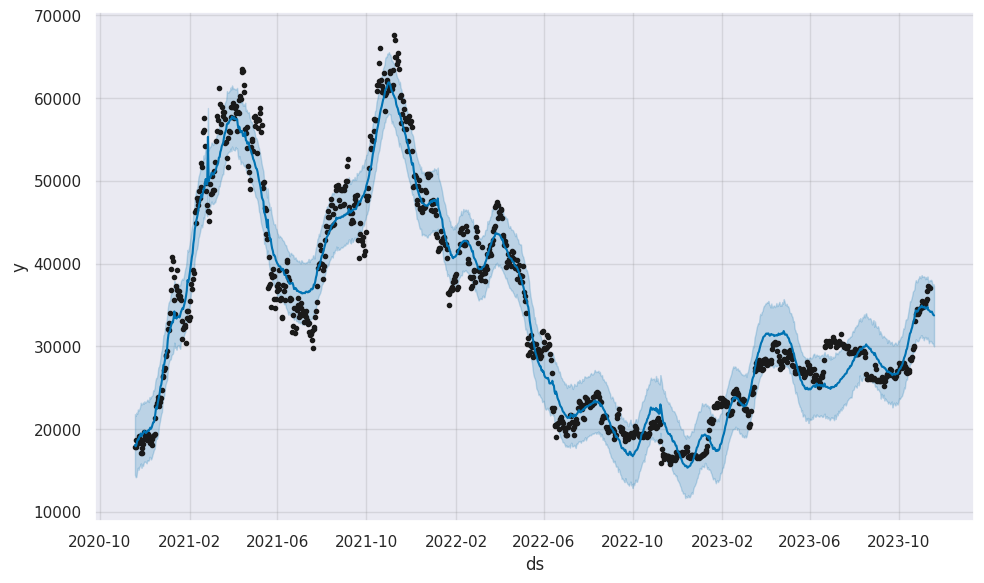

In [ ]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)
# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

The components plot has one additional chart for the additional regressor.

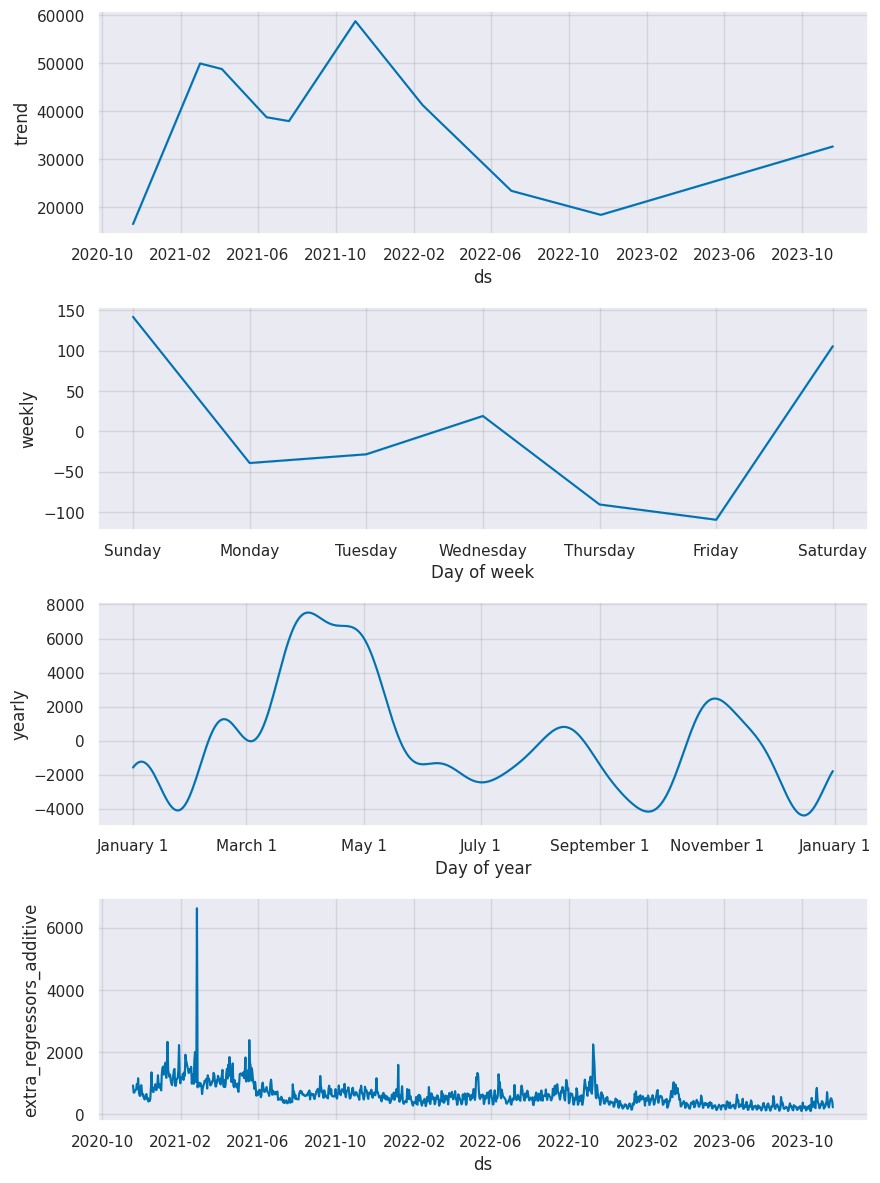

In [ ]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [ ]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')
# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 2545.7998283128823
The MAPE for the multivariate model is 0.06933427030492335


Privious results

The MAE for the baseline model is 2948.1421200168857

The MAPE for the baseline model is 0.08033596067000771

The multivariate model performance is better than the univariate model.

MAE decreased to 2546 from the univariate seasonality model’s 2948.

MAPE decreased to 0.0693 from the univariate seasonality model’s 0.0803

##Step 8: Some additional params

In step 8, we will train the time series model using the training dataset.

interval_width specifies the prediction interval. We changed the default value of 80% to 90% prediction interval. It makes the upper bound and the lower bound of the prediction broader.

n_changepoints is the number of change points in the time series trend. The default value is 25. Based on the shape of the Bitcoin price data, it was set at 7.

In [ ]:
# Create the prophet model with confidence internal of 90%
model_multivariate_2 = Prophet(interval_width=0.90, n_changepoints=7, yearly_seasonality=False, weekly_seasonality=True)
# Add seasonality
#model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)


# Add regressor
model_multivariate_2.add_regressor('Vol', standardize=False)
# Fit the model on the training dataset
model_multivariate_2.fit(train)



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5o70j23w/3xctf1mi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5o70j23w/hhvk07fi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1512', 'data', 'file=/tmp/tmp5o70j23w/3xctf1mi.json', 'init=/tmp/tmp5o70j23w/hhvk07fi.json', 'output', 'file=/tmp/tmp5o70j23w/prophet_modelg42750zr/prophet_model-20231126134342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:43:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:43:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
13:43:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during p

In [ ]:
# Create a future dataframe for prediction
future_multivariate_2 = model_multivariate_2.make_future_dataframe(periods=6)
future_multivariate_2.tail()

,ds
1091,2023-11-14
1092,2023-11-15
1093,2023-11-16
1094,2023-11-17
1095,2023-11-18


In [ ]:
# Append the regressor values
future_multivariate_2 = pd.merge(future_multivariate_2, data[['ds', 'Vol']], on='ds', how='inner')
# Fill the missing values with the previous value
future_multivariate_3 = future_multivariate_2.fillna(method='ffill')
# Check the data
future_multivariate_2.tail()

,ds,Vol
1091,2023-11-14,23857403554
1092,2023-11-15,27365821679
1093,2023-11-16,26007385366
1094,2023-11-17,22445028430
1095,2023-11-18,11886022717


In [ ]:
# Forecast the future dataframe values
forecast_multivariate_2 = model_multivariate_2.predict(future_multivariate_2)

In [ ]:
# Merge actual and predicted values
performance_multivariate_2 = pd.merge(test, forecast_multivariate_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
# Check MAE value
performance_multivariate_2_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_2_MAE}')
# Check MAPE value
performance_multivariate_2_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_2_MAPE}')

The MAE for the multivariate model is 2545.7998283128823
The MAPE for the multivariate model is 0.06933427030492335


The prediction output contains lots of information. We kept the predicted value yhat and its prediction interval upper and lower bound value.

In [ ]:
# Check the forecasted values and upper/lower bound
forecast_multivariate_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#forecast.head()

,ds,yhat,yhat_lower,yhat_upper
1091,2023-11-14,32108.032624,24476.175638,39505.929018
1092,2023-11-15,32381.617647,25334.318460,39740.904853
1093,2023-11-16,32278.406500,24511.880861,39624.589929
1094,2023-11-17,31958.686233,24437.863215,39248.531867
1095,2023-11-18,31967.634889,24363.370685,39770.420022


The x-axis is the date in the forecast visualization, and the y axis is the Bitcoin close price. The black dots are the actual prices in the training dataset, and the red dots are the actual forecast prices. The blue line is the time series model prediction. The shaded area is the 90% prediction interval.

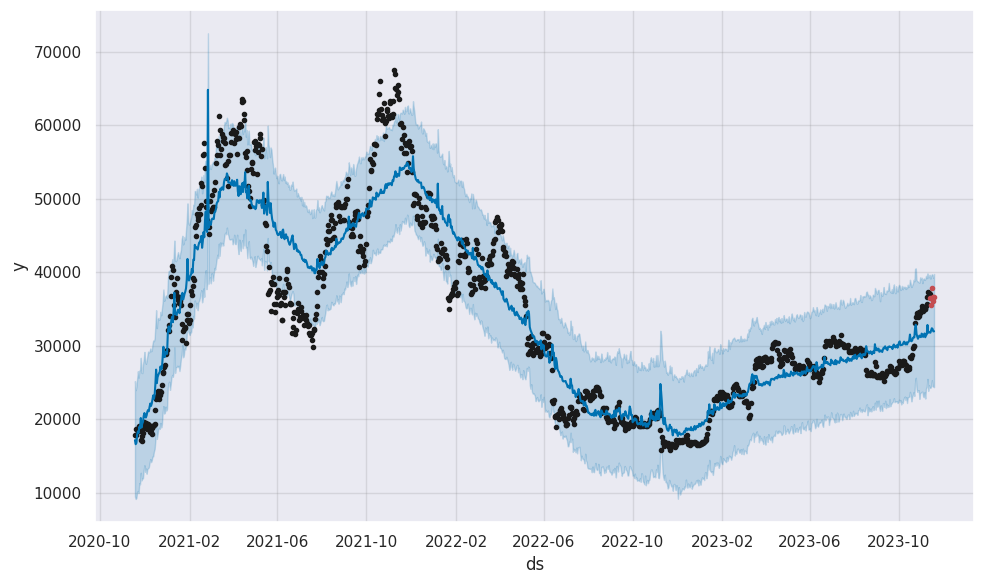

In [ ]:
# Visualize the forecast
fig = model_multivariate_2.plot(forecast_multivariate_2)
ax = fig.gca()
ax.plot( test["ds"], test["y"], 'r.')

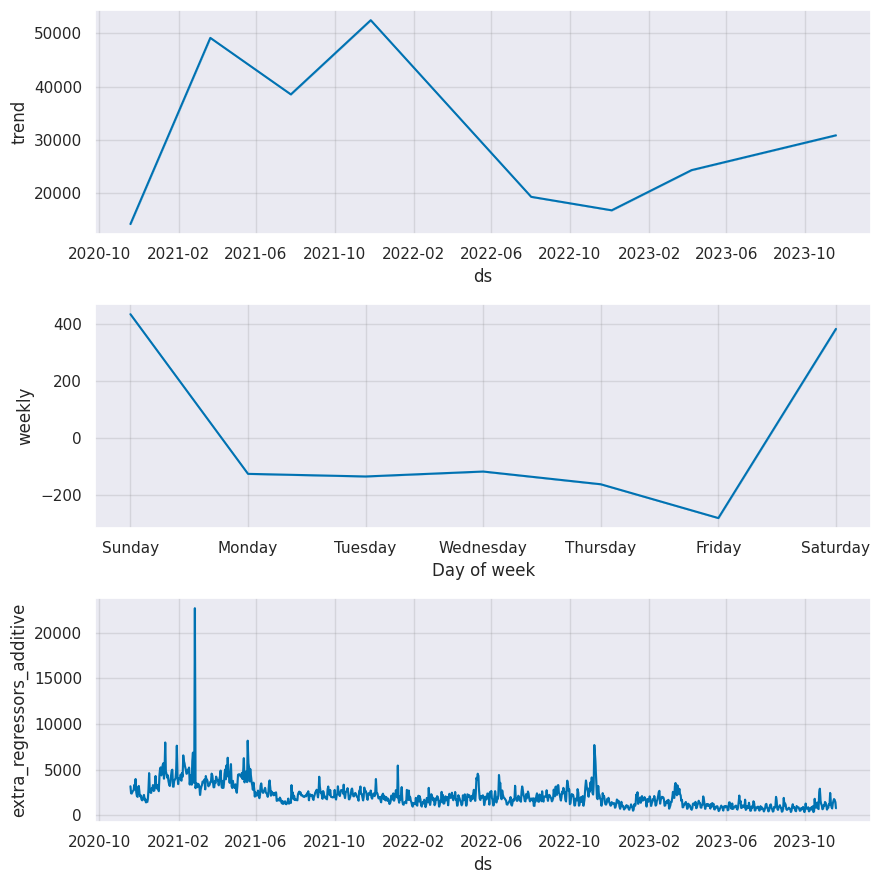

In [ ]:
# Visualize the components
model_multivariate_2.plot_components(forecast_multivariate_2);

##Step 9: Identify Change Points

In step 9, we will discuss how to identify the change points in the time series trend.

Prophet automatically identifies the change points in time series data following the steps below:
1.   Use the data in the first 80% of the time series. The percentage of data is Specify the percentage of data used for identifying change points. The default is 80%.
2.   Identify a large number of uniformly distributed dates with possible trajectories change.
3.   Apply a sparse prior on the magnitudes of the change rate, which is similar to L1 regularization.

We can list the dates corresponding to the changepoints using .changepoints.

In [ ]:
# Default change points
print(f'There are {len(model_multivariate_2.changepoints)} change points. \nThe change points dates are \n{data.loc[data["ds"].isin(model_multivariate_2.changepoints)]}')

There are 7 change points. 
The change points dates are 
            ds             y          Vol
124 2021-03-22  54529.144531  56521454974
249 2021-07-25  35350.187500  20856685287
373 2021-11-26  53569.765625  41810748221
498 2022-03-31  45538.675781  33327427106
622 2022-08-02  22978.117188  28389250717
747 2022-12-05  16974.826172  22209086834
871 2023-04-08  27947.794922   9373255556


In the visualization, the red dotted lines represent the changepoints. It does not include all the seven changepoints in the chart. Only the ones with more changes are included.

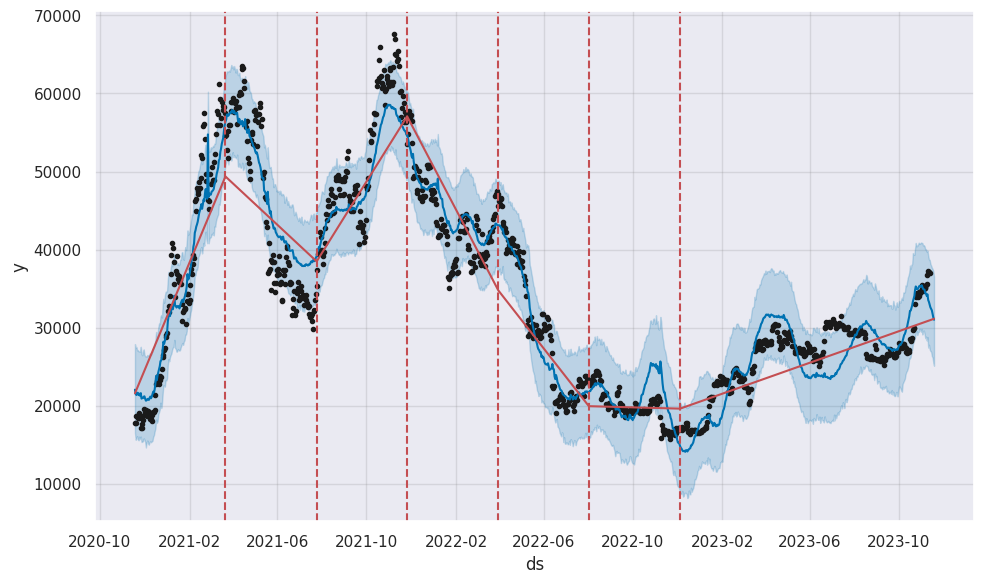

In [ ]:
# Change points to plot
fig = model_multivariate_2.plot(forecast_multivariate_2)
a = add_changepoints_to_plot(fig.gca(), model_multivariate_2, forecast_multivariate_2)

##Step 10: Cross Validation

In step 10, we will do cross-validation for the time series model. Prophet has a cross_validation function to automate the comparison between the actual and the predicted values.

* model_multivariate_2 is the trained model.
* initial='990 days' means the initial model will be trained on the first 990 days of data.
* period='14 days' means 14 days will be added to the training dataset for each additional model.
* horizon = '7 days' means that the model forecasts the next 7 days. When only horizon is given, Prophet defaults initial to be triple the horizon, and period to be half of the horizon.
* parallel="processes" enables parallel processing for cross-validation. When the parallel cross-validation can be done on a single machine, processes provide the highest performance. For larger problems, dask can be used to do cross-validation on multiple machines.

In [ ]:
# Cross validation
df_cv = cross_validation(model_multivariate_2, initial='990 days', period='14 days', horizon = '7 days', parallel="processes")
df_cv.head()

INFO:prophet:Making 7 forecasts with cutoffs between 2023-08-13 00:00:00 and 2023-11-05 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e2708beb490>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5o70j23w/eu0s2mau.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5o70j23w/srl2bigs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5o70j23w/1kzr42kt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5o70j23w/zyxol304.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=436', 'data', 'file=/tmp/tmp5o70j23w/srl2bigs.json', 'init=/tmp/tmp5o70j23w/zyxol304.json', 'output', 'file=/tmp/tmp5o70j23w/prophet_modelqrvvbh9w/prophet_model-20231126140702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:CmdStan args: [

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-08-14,31183.911392,24260.547420,38691.367383,29408.443359,2023-08-13
1,2023-08-15,31191.632445,23787.294867,38119.261603,29170.347656,2023-08-13
2,2023-08-16,31324.879127,24146.105342,38696.950227,28701.779297,2023-08-13
3,2023-08-17,31627.219254,24014.178672,38965.707650,26664.550781,2023-08-13
4,2023-08-18,31490.566569,24137.815163,39052.864820,26049.556641,2023-08-13


##Step 11: Prophet Model Performance Evaluation

Step 11 evaluates the cross-validation model performance.



*  MSE (Mean Squared Error) sums up the squared difference between actual and prediction and is divided by the number of predictions.
*  RMSE (Root Mean Square Error) takes the square root of MSE.
*  MAE (Mean Absolute Error) sums up the absolute difference between actual and prediction and is divided by the number of predictions.
*  MAPE (Mean Absolute Percentage Error) sums up the absolute percentage difference between actual and prediction and is divided by the number of predictions. MAPE is independent of the magnitude of data, so it can be used to compare different forecasts. But it’s undefined when the actual value is zero.
*  MDAPE (Median Absolute Percentage Error) is similar to MAPE. The difference is that it calculates the median instead of taking the average of the absolute percentage difference.
*  SMAPE (Symmetric Mean Absolute Percentage Error) is similar to MAPE. The difference is that when calculating absolute percentage error, the denominator is the actual value for MAPE and the average of the actual and predicted value for SMAPE.

In [ ]:
# Model performance metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,1.619654e+07,4024.492695,3731.409156,0.133613,0.125085,0.126449,1.0
1,2 days,1.499806e+07,3872.732383,3683.924190,0.128523,0.124140,0.122817,1.0
2,3 days,1.690807e+07,4111.941948,4040.853228,0.139218,0.130601,0.134340,1.0
3,4 days,2.017408e+07,4491.556910,4425.829307,0.155158,0.136679,0.147750,1.0
4,5 days,2.284331e+07,4779.467484,4672.086595,0.162555,0.163525,0.155821,1.0
5,6 days,2.322097e+07,4818.813818,4728.916975,0.165081,0.156442,0.157552,1.0
6,7 days,2.262920e+07,4757.016015,4635.742998,0.160115,0.156384,0.153462,1.0


plot_cross_validation_metric method from Prophet helps us to plot the cross-validation performance results.



* The x-axis is the horizon. Because we set the horizon to be 7 days, the x-axis has a value up to 7.
* The y-axis is the metric we are interested in. We use mape as an example in this visualization.
* On each day, we can see 7 dots. This is because there are 7 models in the cross-validation, and each dot represents the MAPE from one model.
* The line is the aggregated performance across all the models. We can see that MAPE value increases with days, which is expected because time series tend to make better predictions for the near future than the far future.

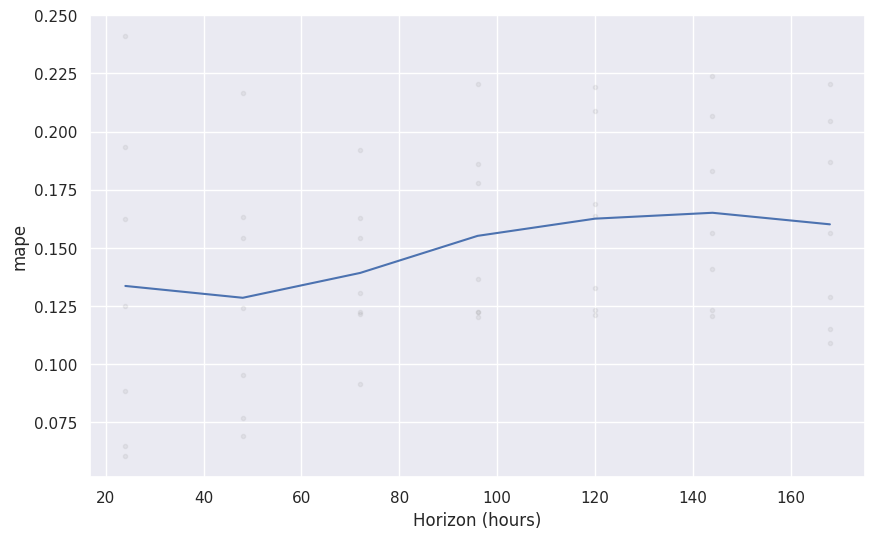

In [ ]:
# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='mape')

## Summary
In this tutorial, we talked about how to make time-series predictions of Bitcoin prices. The following topics are covered:

*   How to train a time series forecasting model using Prophet?
*   How to make predictions and do time series decomposition?
*   How to identify changing points in the trend?
*   How to do time series cross-validation?
*   How to evaluate time series model performance using Prophet?

## Выводы

Годовая сезонность не дает эффекта

Недельную сезонность пожалуй стоит учитывать

При введении объемов торгов, как доп. параметра, качество прогноза несколько улучшается

Итоговая оценка модели дает ошибку MAPE в 12,6%

## Что дальше?

Пожалуй можно попробовать построить простенькую торговую систему вокруг этого варианта предсказания

##This notebook is made based on the following matirials

*  Seasonality, Holiday Effects, And Regressors

https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

*  Multivariate Time Series Forecasting With Seasonality And Holiday Effect Using Prophet In Python

https://grabngoinfo.com/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python/


*  Time Series Forecasting Of Bitcoin Prices Using Prophet

https://grabngoinfo.com/time-series-forecasting-of-bitcoin-prices-using-prophet/

*   yfinance-guide

https://algotrading101.com/learn/yfinance-guide/

